# DistilBERT Resume Experience Classifier (Junior / Mid / Senior)

In this notebook we fine-tune **DistilBERT** to predict the `experience_level` label from resume data stored in `cleaned_resumes.csv`.

## PipeLine

- Load the cleaned dataset and inspect its shape/columns and class balance.
- Build a single `text` field per resume by concatenating all non-target columns, prefixed like `[skills] ...` to keep structure.
- Convert string labels (`junior`, `mid`, `senior`) into integer IDs (`label2id`) and keep a reverse mapping (`id2label`).
- Create a **stratified** train/test split so each split keeps the same label proportions.
- Tokenize with `distilbert-base-uncased` (truncate long inputs up to 512 tokens and pad so we can batch).
- Wrap tokenized inputs + labels in a PyTorch `Dataset` for the HuggingFace `Trainer`.
- Train with `TrainingArguments` + `Trainer`, evaluating each epoch and selecting the best checkpoint by **macro F1**.
- Evaluate on the test set (accuracy, macro-F1, classification report, confusion matrix) and visualize the confusion matrix.

## Imports

- **`pandas as pd`**: load `cleaned_resumes.csv` into a DataFrame and build new columns like `text` and `label`.
- **`numpy as np`**: turn model logits into predicted class IDs via `np.argmax`.
- **`re`**: normalize text by collapsing repeated whitespace (keeps inputs cleaner/consistent).
- **`train_test_split`** (`sklearn.model_selection`): reproducible, stratified train/test split.
- **`accuracy_score`, `f1_score`, `classification_report`, `confusion_matrix`** (`sklearn.metrics`): evaluation metrics + diagnostics.
- **`torch`**: tensor conversions and a custom `torch.utils.data.Dataset`.
- **`AutoTokenizer`** (`transformers`): load the matching tokenizer for our model checkpoint.
- **`AutoModelForSequenceClassification`** (`transformers`): DistilBERT + a classification head for 3 classes.
- **`TrainingArguments`, `Trainer`** (`transformers`): configure and run the training loop (batching, optimization, evaluation, checkpointing).

In [1]:
import os
import certifi

# Fix TLS certificate error caused by PostgreSQL setting SSL_CERT_FILE
# to a non-existent path. Use certifi's certificate bundle instead.
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no gpu")

c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda
GPU: NVIDIA GeForce RTX 5060 Ti
True
NVIDIA GeForce RTX 5060 Ti


# Load Data

In this cell we load our cleaned dataset from `cleaned_resumes.csv` and do quick sanity checks before we build features.

- **`CSV_PATH`**: the file we read from disk.
- **`TARGET_COL`**: the label we want to predict (`experience_level`).
- **`pd.read_csv(..., engine="python")`**: loads the CSV into a DataFrame. (Using the Python engine is a safe fallback if the file has tricky formatting.)
- **Printed checks**:
  - `df.shape`: confirms how many rows/columns we’re training on.
  - `df.columns`: shows which fields we’ll later concatenate into text.
  - `value_counts` on `TARGET_COL`: confirms whether classes are balanced (important for training stability and for interpreting accuracy/F1).

In [2]:
CSV_PATH = "cleaned_resumes.csv"
TARGET_COL = "experience_level"

df = pd.read_csv(
    "cleaned_resumes.csv",
    engine="python",
)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

print("\nTarget distribution:\n", df[TARGET_COL].value_counts(dropna=False))

Shape: (2100, 15)
Columns: ['experience', 'projects', 'skills', 'summary', 'education', 'job title', 'total_experience_time', 'last_experience_time', 'summary_count', 'last_experience_only', 'experience_level', 'name', 'email', 'linkedin', 'github']

Target distribution:
 experience_level
senior    700
mid       700
junior    700
Name: count, dtype: int64


# Prepare Text Data

Transformer models (like RoBERTa) work on **text sequences**, but our DataFrame has many separate columns (experience, projects, skills, summary, education, etc.). We need to merge them into a single `text` field per row so the model can see all the information at once.

## What we do here

1. **`clean_value(v)`**: takes any cell value (string, number, or missing) and returns a clean string. If the value is missing (`pd.isna`), we return an empty string. Otherwise we convert to string, collapse repeated whitespace into single spaces, and strip leading/trailing whitespace.
2. **`row_to_text(row, target_col)`**: builds a **natural resume format** by combining columns in a realistic order: Name, Contact Info, Summary, Experience, Education, Skills, Projects. This matches the format used in Test 2 data for consistency during evaluation.
3. **Apply to DataFrame**: we create a new column `df["text"]` by applying `row_to_text` to every row.
4. **Print a sample**: we show a portion of one resume's text to confirm the format looks correct, and we print the average text length in characters to get a sense of how long our inputs are (important for choosing `max_length` during tokenization).

## Why this matters

- **Natural format**: the resume text looks like a real resume (Name, Summary, Experience, Education, Skills) which matches how test data is formatted.
- **Single sequence**: the tokenizer and model expect one text string per example, not a dictionary of columns.
- **Average length**: knowing the typical character count helps us decide if 512 tokens is enough or if we're truncating a lot of information.

In [3]:
def clean_value(v):
    """Clean a cell value - return empty string if missing, otherwise clean whitespace."""
    if pd.isna(v):
        return ""
    s = str(v)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def row_to_text(row, target_col):
    """
    Build resume text in a natural format (like a real resume).
    This matches the format used in Test 2 data for consistency.
    """
    parts = []
    
    # 1. Contact Info (Name, Email, LinkedIn, GitHub)
    name = clean_value(row.get('name', ''))
    email = clean_value(row.get('email', ''))
    linkedin = clean_value(row.get('linkedin', ''))
    github = clean_value(row.get('github', ''))
    
    if name and name.lower() not in ['unknown', 'not provided']:
        parts.append(name)
    
    contact_parts = []
    if email and email.lower() not in ['unknown', 'not provided']:
        contact_parts.append(email)
    if linkedin and linkedin.lower() not in ['unknown', 'not provided']:
        contact_parts.append(linkedin)
    if github and github.lower() not in ['unknown', 'not provided']:
        contact_parts.append(github)
    if contact_parts:
        parts.append(' | '.join(contact_parts))
    
    # 2. Summary
    summary = clean_value(row.get('summary', ''))
    if summary:
        parts.append('\nSUMMARY\n' + summary)
    
    # 3. Experience
    experience = clean_value(row.get('experience', ''))
    if experience:
        parts.append('\nEXPERIENCE\n' + experience)
    
    # 4. Education
    education = clean_value(row.get('education', ''))
    if education:
        parts.append('\nEDUCATION\n' + education)
    
    # 5. Skills
    skills = clean_value(row.get('skills', ''))
    if skills:
        parts.append('\nSKILLS\n' + skills)
    
    # 6. Projects
    projects = clean_value(row.get('projects', ''))
    if projects and projects.lower() not in ['no projects made', 'not provided']:
        parts.append('\nPROJECTS\n' + projects)
    
    return '\n'.join(parts)

df["text"] = df.apply(lambda r: row_to_text(r, TARGET_COL), axis=1)

print(df["text"].iloc[0][:1500])
print("\nAverage text length (chars):", int(df["text"].str.len().mean()))

[experience] Experience 1: Company: Campbell-Powell. Title: qa engineer. Level: mid. Start Date: 2006-01-19. End Date: 2011-10-17. Duration: 5.74 years. Responsibilities: Perfected data analysis and data visualization using Python and Tableau. Developed and deployed scalable solutions. Integrated third-party services into existing systems. Performed software testing and resolved bugs efficiently.. Technologies: CI/CD. Methodologies: Scrum. Tools: Git, Docker, Docker. Industry: Technology. Company Size: Large. Experience 2: Company: Price Group. Title: qa engineer. Start Date: 2011-10-17. End D

Average text length (chars): 3296


# Create Label Mappings

Neural network classifiers output logits (raw scores) for each class, and we need to map string labels like `"junior"`, `"mid"`, `"senior"` to integer IDs (0, 1, 2) so PyTorch can compute loss and predictions.

## What we do here

1. **`labels = sorted(df[TARGET_COL].dropna().unique().tolist())`**: get all unique label values from the target column, drop any missing values, sort alphabetically, and convert to a list. Sorting ensures the mapping is deterministic (always `junior=0`, `mid=1`, `senior=2`).
2. **`label2id`**: a dictionary mapping each label string to its integer ID (e.g., `{"junior": 0, "mid": 1, "senior": 2}`).
3. **`id2label`**: the reverse mapping (e.g., `{0: "junior", 1: "mid", 2: "senior"}`). We'll pass this to the model so it can label predictions with human-readable names.
4. **`df["label"]`**: create a new column with the integer label for each row by applying `label2id` to the `experience_level` column.

## Why this matters

- **Loss computation**: PyTorch's `CrossEntropyLoss` expects integer targets (not strings).
- **Consistency**: sorting ensures the same label gets the same ID every time we run the notebook.
- **Interpretability**: `id2label` lets us decode model predictions back into `"junior"`, `"mid"`, `"senior"` for reports and confusion matrices.

In [4]:
labels = sorted(df[TARGET_COL].dropna().unique().tolist())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

df["label"] = df[TARGET_COL].map(label2id)

print("Labels:", labels)

Labels: ['junior', 'mid', 'senior']


# Train/Test Split

We split our dataset into **training** and **test** sets so we can evaluate how well the model generalizes to unseen data. A naive random split might accidentally put more juniors in the train set and more seniors in the test set, which would make evaluation misleading.

## What we do here

- **`train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])`**:
  - `test_size=0.2`: reserve 20% of rows for testing (420 out of 2100), use the remaining 80% for training (1680 rows).
  - `random_state=42`: makes the split reproducible (same split every time we run the notebook).
  - **`stratify=df["label"]`**: ensures each split has the same proportion of junior/mid/senior labels. For example, if the full dataset is 33% junior, 33% mid, 33% senior, both train and test will also be 33%/33%/33%. This prevents class imbalance from biasing our evaluation metrics.

## Why stratification matters

If we did a random split without stratification, we might end up with 40% juniors in train but only 25% in test. Then a model that's good at predicting juniors would look artificially worse on the test set (or vice versa). Stratification keeps the class distribution identical in both splits, so accuracy and F1 scores reflect true performance.

In [5]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (1680, 17) Test: (420, 17)


# Tokenization

Transformers don't work with raw text—they work with **token IDs** (integers representing subwords from a vocabulary). We use the DistilBERT tokenizer to convert our `text` strings into the format the model expects.

## What we do here

1. **`MODEL_NAME = "distilbert-base-uncased"`**: the HuggingFace checkpoint we're using. "uncased" means it lowercases everything (so "Python" and "python" are treated the same).
2. **`AutoTokenizer.from_pretrained(MODEL_NAME)`**: downloads (or loads from cache) the tokenizer that matches this checkpoint. It knows the vocabulary and special tokens (`[CLS]`, `[SEP]`, `[PAD]`) that DistilBERT expects.
3. **`MAX_LEN = 512`**: DistilBERT's maximum sequence length. Longer texts get truncated, shorter texts get padded with `[PAD]` tokens.
4. **`tokenize(texts)`** function:
   - `truncation=True`: if a text is longer than 512 tokens, cut it off at 512.
   - `padding=True`: if a text is shorter than 512 tokens, add `[PAD]` tokens to reach 512 (so all sequences in a batch have the same length).
   - `max_length=MAX_LEN`: explicitly set the target length.
   - Returns a dictionary with `input_ids` (token IDs) and `attention_mask` (1 for real tokens, 0 for padding).
5. **Apply to train/test**: we tokenize all training texts into `train_enc` and all test texts into `test_enc`. Each is a dictionary of lists (one list per field: `input_ids`, `attention_mask`).

## Why truncation and padding matter

- **Truncation**: some resumes are very long (thousands of characters). If we don't truncate, the model can't process them (DistilBERT has a hard limit of 512 tokens). We lose some information, but the first 512 tokens usually contain the most important details.
- **Padding**: batching requires all sequences in a batch to have the same length. Padding to 512 lets us stack sequences into a tensor. The `attention_mask` tells the model to ignore padded positions during self-attention.

In [6]:
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 512
def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )

train_enc = tokenize(train_df["text"].tolist())
test_enc  = tokenize(test_df["text"].tolist())


# Create PyTorch Datasets

The HuggingFace `Trainer` expects data in the form of a PyTorch `Dataset` (an object that can be indexed like `dataset[i]` and returns a dictionary of tensors). We wrap our tokenized encodings and labels into a custom `Dataset` class.

## What we do here

1. **`ResumeDataset` class**:
   - `__init__(self, encodings, labels)`: stores the tokenized encodings (a dict with `input_ids`, `attention_mask`, etc.) and the list of integer labels.
   - `__len__(self)`: returns the number of examples (needed for batching).
   - `__getitem__(self, idx)`: returns a single example as a dictionary of PyTorch tensors. For index `idx`, we extract the `idx`-th slice from each encoding field (`input_ids[idx]`, `attention_mask[idx]`) and convert them to tensors. We also add the label as `item["labels"]` (the `Trainer` expects the key to be `"labels"` for computing loss).
2. **Instantiate datasets**:
   - `train_dataset = ResumeDataset(train_enc, train_df["label"].tolist())`: wraps the training encodings and labels.
   - `test_dataset = ResumeDataset(test_enc, test_df["label"].tolist())`: wraps the test encodings and labels.

## Why we need this

The `Trainer` internally creates a `DataLoader` that batches examples by calling `dataset[i]` for each index in a batch. Our `ResumeDataset` provides the interface the `Trainer` expects: given an index, return a dict with `input_ids`, `attention_mask`, and `labels` as tensors.

In [7]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = ResumeDataset(train_enc, train_df["label"].tolist())
test_dataset  = ResumeDataset(test_enc,  test_df["label"].tolist())


# Load Pre-trained Model

We start with a **pre-trained** DistilBERT model (trained on massive amounts of text to understand language) and add a **classification head** on top (a linear layer that maps the model's hidden states to 3 class logits).

## What we do here

- **`AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, ...)`**:
  - `MODEL_NAME = "distilbert-base-uncased"`: loads the pre-trained DistilBERT weights from HuggingFace.
  - `num_labels=len(labels)`: tells the model we have 3 classes (junior, mid, senior). The model automatically adds a classification head with 3 output neurons.
  - `id2label=id2label, label2id=label2id`: pass our label mappings so the model can decode predictions into human-readable names (useful for logging and debugging).

## What happens under the hood

1. The model downloads the pre-trained DistilBERT weights (or loads from cache).
2. It initializes a new classification head (a linear layer from hidden size 768 to 3 classes). The warning message confirms that `classifier.weight`, `classifier.bias`, `pre_classifier.weight`, and `pre_classifier.bias` are **randomly initialized** (not pre-trained), so we need to train them.
3. During training, the `Trainer` will fine-tune **both** the pre-trained DistilBERT layers (slightly adjusting the language understanding) **and** the new classification head (learning to map resume text to junior/mid/senior).

## Why fine-tuning works

Pre-trained models already know grammar, semantics, and context from their original training. By fine-tuning on our resume data, we adapt that general knowledge to the specific task of predicting experience level. This is much faster and more accurate than training from scratch.

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }


# Training Setup and Execution

Now we configure **how** the model trains (learning rate, batch size, number of epochs, evaluation strategy) and define **what metrics** we track during training. Then we run the training loop and save the fine-tuned model.

## Metrics function: `compute_metrics`

- **Purpose**: the `Trainer` calls this function after each evaluation to compute custom metrics beyond loss.
- **Input**: `eval_pred` is a tuple `(logits, y_true)` where `logits` is a 2D array (num_examples × 3 classes) and `y_true` is a 1D array of true labels.
- **Logic**:
  1. `y_pred = np.argmax(logits, axis=1)`: convert logits to predicted class IDs by taking the class with the highest score.
  2. Return a dictionary with `accuracy` (fraction of correct predictions) and `f1_macro` (average F1 across all classes, treating each class equally).
- **Why macro F1**: in multi-class problems, macro F1 is fairer than accuracy when classes are imbalanced or when we care equally about all classes. It averages the F1 score of junior, mid, and senior, so a model that only predicts "senior" won't get a high macro F1.

## Training arguments: `TrainingArguments`

- **`output_dir="distilbert_resume_level"`**: where to save checkpoints and the final model.
- **`eval_strategy="epoch"`**: run evaluation on the test set at the end of each epoch (so we can track how metrics improve over time).
- **`save_strategy="epoch"`**: save a checkpoint at the end of each epoch.
- **`load_best_model_at_end=True`**: after training finishes, reload the checkpoint with the best metric (instead of the last checkpoint).
- **`metric_for_best_model="f1_macro"`**: use macro F1 to decide which checkpoint is "best" (higher is better).
- **`learning_rate=5e-5`**: the step size for the optimizer (Adam). 5e-5 is a common default for fine-tuning BERT-like models.
- **`per_device_train_batch_size=16`**: process 16 examples per forward/backward pass on each GPU (or CPU). Larger batches train faster but use more memory.
- **`per_device_eval_batch_size=32`**: during evaluation we don't compute gradients, so we can use a larger batch size to speed up inference.
- **`num_train_epochs=5`**: train for 5 full passes over the training data. More epochs can improve performance but risk overfitting.
- **`logging_steps=50`**: print training loss every 50 steps (useful for monitoring progress).
- **`report_to="none"`**: disable automatic logging to WandB/TensorBoard (we just print to console).

### Example: what happens if we change `num_train_epochs`?

- **Fewer epochs (e.g., 2)**: training finishes faster, but the model might not fully converge (metrics could still be improving).
- **More epochs (e.g., 10)**: the model might overfit (training loss keeps dropping but test metrics plateau or degrade).
- **Best practice**: monitor the evaluation metrics each epoch. If macro F1 stops improving (or starts dropping), we can stop early or use the best checkpoint.

## Trainer and training loop

1. **`Trainer(...)`**: wraps the model, datasets, arguments, tokenizer, and metrics function.
   - `model=model`: the DistilBERT model we loaded.
   - `args=args`: the `TrainingArguments` we just defined.
   - `train_dataset=train_dataset`: the 1680 training examples.
   - `eval_dataset=test_dataset`: the 420 test examples (used for evaluation each epoch).
   - `tokenizer=tokenizer`: passed so the `Trainer` can pad/collate batches correctly.
   - `compute_metrics=compute_metrics`: our custom metrics function.
2. **`trainer.train()`**: runs the training loop. For each epoch:
   - Shuffle the training data and split into batches of 16.
   - For each batch: forward pass → compute loss → backward pass → update weights.
   - At the end of the epoch: run evaluation on the test set, compute accuracy and macro F1, save a checkpoint.
   - After all epochs: reload the best checkpoint (the one with the highest macro F1).
3. **Save the model**:
   - `trainer.save_model(args.output_dir)`: saves the fine-tuned model weights to `distilbert_resume_level/`.
   - `tokenizer.save_pretrained(args.output_dir)`: saves the tokenizer config so we can reload the model later without re-downloading.

## What the training output shows

The table in the output shows training loss, validation loss, accuracy, and macro F1 for each epoch. We can see if the model is improving (metrics going up) or overfitting (training loss dropping but validation metrics plateauing).

In [10]:
args = TrainingArguments(
    output_dir="roberta_resume_level",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",

    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,

    logging_steps=50,
    report_to="none"
)


In [11]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# Save model and tokenizer
print(f"\nSaving model to {args.output_dir}...")
trainer.save_model(args.output_dir)
tokenizer.save_pretrained(args.output_dir)

# Verify files were saved
saved_files = os.listdir(args.output_dir)
print(f"Saved files: {saved_files}")

# Check for model weights
has_weights = any(f.endswith('.bin') or f.endswith('.safetensors') for f in saved_files)
if has_weights:
    print("Model weights saved successfully!")
else:
    print("WARNING: Model weights may not have been saved!")

print(f"Saved model + tokenizer to: {args.output_dir}")


C:\Users\Rane\AppData\Local\Temp\ipykernel_20332\1179946624.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.738700,0.675599,0.685714,0.677375
2,0.720600,0.651773,0.671429,0.659060
3,0.661500,0.648165,0.690476,0.662682
4,0.609600,0.619442,0.726190,0.709059
5,0.504300,0.614388,0.740476,0.731112



Saving model to roberta_resume_level...
Saved files: ['checkpoint-105', 'checkpoint-210', 'checkpoint-315', 'checkpoint-420', 'checkpoint-525', 'config.json', 'merges.txt', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'training_args.bin', 'vocab.json']
Model weights saved successfully!
Saved model + tokenizer to: roberta_resume_level


In [12]:
pred = trainer.predict(test_dataset)

y_true = test_df["label"].to_numpy()
y_pred = np.argmax(pred.predictions, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

print("\nReport:\n", classification_report(y_true, y_pred, target_names=labels))
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.7404761904761905
Macro-F1: 0.7311119059095929

Report:
               precision    recall  f1-score   support

      junior       0.96      0.79      0.87       140
         mid       0.74      0.46      0.57       140
      senior       0.62      0.97      0.76       140

    accuracy                           0.74       420
   macro avg       0.77      0.74      0.73       420
weighted avg       0.77      0.74      0.73       420


Confusion matrix:
 [[111  18  11]
 [  5  64  71]
 [  0   4 136]]


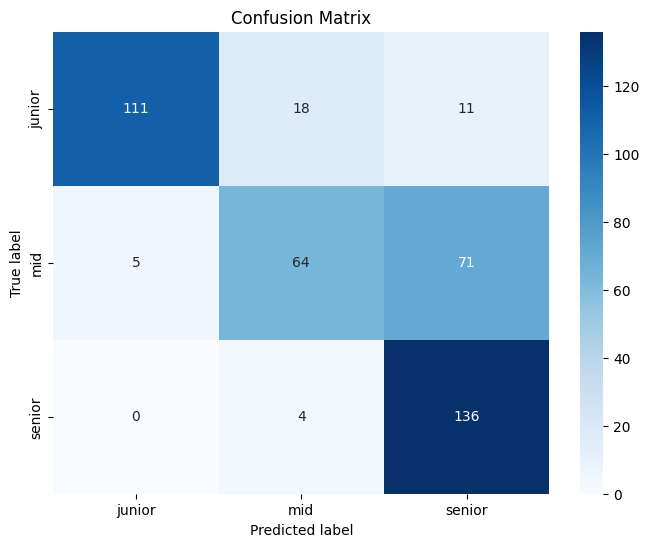

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Evaluation and Detailed Results

After training, we run a final evaluation on the test set to get detailed metrics and visualize where the model succeeds and where it struggles.

## Prediction and metrics

1. **`trainer.predict(test_dataset)`**: runs inference on all 420 test examples and returns a `PredictionOutput` object with:
   - `predictions`: the raw logits (420 × 3 array).
   - `label_ids`: the true labels (420-element array).
   - `metrics`: evaluation metrics (computed by `compute_metrics`).
2. **Convert logits to predictions**:
   - `y_true = test_df["label"].to_numpy()`: get the true labels from the test DataFrame.
   - `y_pred = np.argmax(pred.predictions, axis=1)`: for each example, take the class with the highest logit as the predicted label.
3. **Print metrics**:
   - **Accuracy**: fraction of correct predictions (0.726 = 72.6%).
   - **Macro F1**: average F1 score across the 3 classes (0.721). This is the metric we optimized during training.
   - **Classification report**: shows precision, recall, and F1 for each class individually. For example, if precision for "junior" is 0.94, it means 94% of examples the model predicted as junior were actually junior. If recall for "mid" is 0.47, it means the model only correctly identified 47% of the actual mid-level resumes.
   - **Confusion matrix**: a 3×3 table where row `i` is the true class and column `j` is the predicted class. The diagonal shows correct predictions; off-diagonal entries show misclassifications. For example, if confusion matrix shows `[8, 66]` in the "mid" row, it means 8 mid-level resumes were misclassified as junior and 66 were misclassified as senior.

## Visualization: confusion matrix heatmap

1. **Import plotting libraries**: `matplotlib.pyplot` for the figure and `seaborn` for the heatmap styling.
2. **Compute confusion matrix**: `confusion_matrix(y_true, y_pred)` returns a 3×3 array.
3. **Plot**:
   - `plt.figure(figsize=(8, 6))`: create an 8×6 inch figure.
   - `sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)`: draw a heatmap where each cell shows the count of examples. `annot=True` displays the numbers inside each cell, `fmt="d"` formats them as integers, `cmap="Blues"` uses a blue color scale, and `xticklabels`/`yticklabels` label the axes with "junior", "mid", "senior".
   - `plt.xlabel`, `plt.ylabel`, `plt.title`: add axis labels and a title.
   - `plt.show()`: display the plot.

## Why the confusion matrix matters

The confusion matrix reveals **which classes the model confuses**. For example, if the model often predicts "senior" when the true label is "mid", we might need more training data for mid-level resumes or better features to distinguish mid from senior. The heatmap makes these patterns easy to spot visually.

In [14]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.7404761904761905
